In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Set a random seed for reproducibility
np.random.seed(42)


In [6]:

# Define the Hindmarsh-Rose model
def hr_neuron_model(state, t, I, r):
    x, y, z = state
    dxdt = y + 3 * x**2 - x**3 - z + I
    dydt = 1 - 5 * x**2 - y
    dzdt = r * (4 * (x + 8.5) - z)
    return [dxdt, dydt, dzdt]

# Initial conditions and integration parameters
initial_state = [-1.0, 2.0, 0.5]
I, r = 3.29, 0.003
t = np.arange(0, 1500, 0.005)

# Integrate the HR model
solution = odeint(hr_neuron_model, initial_state, t, args=(I, r))
x = solution[:, 0]

# Normalize the data
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x.reshape(-1, 1)).flatten()


In [3]:
# Define the ESN class
class EchoStateNetwork:
    def __init__(self, N_res, p, alpha, rho):
        self.N_res = N_res
        self.p = p
        self.alpha = alpha
        self.rho = rho
        self.Win = np.random.uniform(-0.5, 0.5, (N_res, 1))
        self.Wres = self.initialize_reservoir(N_res, p, rho)
        self.Wout = None

    def initialize_reservoir(self, N_res, p, rho):
        W = np.random.uniform(-1, 1, (N_res, N_res))
        mask = np.random.rand(N_res, N_res) < p
        W[~mask] = 0
        spectral_radius = np.max(np.abs(np.linalg.eigvals(W)))
        W *= rho / spectral_radius
        return W

    def train(self, u, y_target):
        states = np.zeros((len(u), self.N_res))
        for t in range(1, len(u)):
            states[t] = (1 - self.alpha) * states[t-1] + self.alpha * np.tanh(np.dot(self.Wres, states[t-1]) + self.Win.flatten() * u[t])
        reg = Ridge(alpha=1e-6)
        reg.fit(states, y_target)
        self.Wout = reg.coef_

    def predict(self, u):
        states = np.zeros((len(u), self.N_res))
        y_pred = np.zeros(len(u))
        for t in range(1, len(u)):
            states[t] = (1 - self.alpha) * states[t-1] + self.alpha * np.tanh(np.dot(self.Wres, states[t-1]) + self.Win.flatten() * u[t])
            y_pred[t] = np.dot(self.Wout, states[t])
        return y_pred

In [4]:

# ESN hyperparameters from Problem B1
params_list = [
    {'N_res': 966, 'p': 0.4, 'alpha': 0.9, 'rho': 0.72, 'label': 'Prob-B-1a'},
    {'N_res': 300, 'p': 0.30, 'alpha': 0.2, 'rho': 0.87, 'label': 'Prob-B-1b'},
    {'N_res': 433, 'p': 0.1, 'alpha': 0.2, 'rho': 0.87, 'label': 'Prob-B-1c'},
    {'N_res': 566, 'p': 1.0, 'alpha': 0.30, 'rho': 0.56, 'label': 'Prob-B-1d'}
]

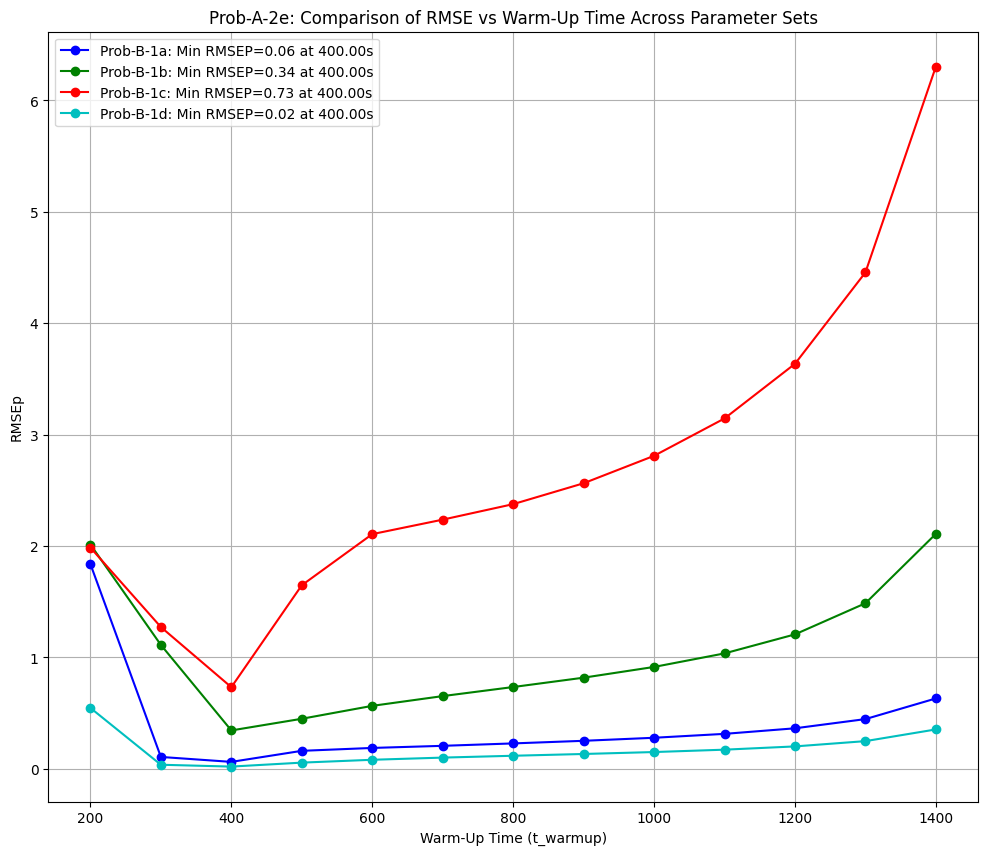

In [5]:


dt = 0.005
# Range for N_warmup
N_warmup_range = np.arange(40001, 300001, 20000)

# Initialize plot
plt.figure(figsize=(12, 10))
colors = ['b', 'g', 'r', 'c']  # Color for each parameter set

# Loop through each parameter set and plot RMSE
for idx, params in enumerate(params_list):
    label = params.pop('label')
    esn = EchoStateNetwork(**params)
    esn.train(x_normalized[:40000], x_normalized[1:40001])  # Initial training
    rmse_values = []
    for N_warmup in N_warmup_range:
        training_data = x_normalized[:N_warmup]
        testing_data = x_normalized[N_warmup:]
        esn.train(training_data[:-1], training_data[1:])
        predicted = esn.predict(testing_data[:-1])
        predicted_denorm = scaler.inverse_transform(predicted.reshape(-1, 1)).flatten()
        testing_data_denorm = scaler.inverse_transform(testing_data[1:].reshape(-1, 1)).flatten()
        rmse = np.sqrt(np.mean((predicted_denorm - testing_data_denorm)**2))
        rmse_values.append(rmse)

    # Find minimum RMSE and corresponding warm-up time
    min_rmse = min(rmse_values)
    min_warmup_time = N_warmup_range[np.argmin(rmse_values)] * dt

    # Plot RMSE vs. Warm-Up Time for each parameter set
    plt.plot(N_warmup_range * dt, rmse_values, marker='o', color=colors[idx], label=f'{label}: Min RMSEP={min_rmse:.2f} at {min_warmup_time:.2f}s')

# Add labels, legend, and grid
plt.xlabel('Warm-Up Time (t_warmup)')
plt.ylabel('RMSEp')
plt.title('Prob-A-2e: Comparison of RMSE vs Warm-Up Time Across Parameter Sets')
plt.legend()
plt.grid(True)
plt.savefig('Prob-B-2d.png')
plt.show()
